Krzysztof Sołowiej

krsolowiej@gmail.com

https://github.com/KrzysztofSolowiej/public_projects

http://krsolowiej.pythonanywhere.com/

# Analiza liczby interwencji straży pożarnej i danych pogodowych

# Budowa prostych modeli przewidywania

In [1]:
import requests
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot
from sklearn.linear_model import Lasso
from itertools import product
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import Normalizer
import pickle
import joblib
from flask import Flask, request, jsonify, render_template, escape
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


url = 'https://otwartedane.gdynia.pl/dataset/cddc4963-6fe0-4ca8-bbd9-963622cb5030/resource/e0fd1bb6-d4cf-4c13-96e6-b964d1600bc5/download/city_9_2_data.csv'

data = pd.read_csv(url, sep=',', parse_dates = ['month'])
df = pd.DataFrame(data)
df

,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem,month
0,12,172,28,212,2015-01-01
1,11,92,39,142,2015-02-01
2,10,110,66,186,2015-03-01
3,8,114,65,187,2015-04-01
4,10,141,57,208,2015-05-01
...,...,...,...,...,...
88,15,211,31,257,2021-11-01
89,17,158,30,205,2021-12-01
90,30,363,40,433,2022-01-01
91,15,182,29,226,2022-02-01


# Wstępna eksploracja danych

In [2]:
df.dtypes

liczba_falszywych_alarmow               int64
liczba_zagrozen_miejscowych             int64
liczba_pozarow                          int64
razem                                   int64
month                          datetime64[ns]
dtype: object

In [3]:
print(df.shape)
df.columns

(93, 5)


Index(['liczba_falszywych_alarmow', 'liczba_zagrozen_miejscowych',
       'liczba_pozarow', 'razem', 'month'],
      dtype='object')

In [4]:
df.isnull().sum()

liczba_falszywych_alarmow      0
liczba_zagrozen_miejscowych    0
liczba_pozarow                 0
razem                          0
month                          0
dtype: int64

In [5]:
df.describe()

,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem
count,93.000000,93.000000,93.000000,93.000000
mean,14.752688,172.236559,41.623656,228.612903
std,6.012046,65.390532,14.563888,67.269418
min,4.000000,81.000000,13.000000,129.000000
25%,10.000000,128.000000,30.000000,181.000000
50%,14.000000,158.000000,38.000000,212.000000
75%,18.000000,199.000000,53.000000,260.000000
max,34.000000,422.000000,81.000000,478.000000


Zmiana nazwy kolumny i dane czasowe

In [6]:
col_dict = {'month':'data'}
df = df.rename(columns=col_dict)
df.head()

,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem,data
0,12,172,28,212,2015-01-01
1,11,92,39,142,2015-02-01
2,10,110,66,186,2015-03-01
3,8,114,65,187,2015-04-01
4,10,141,57,208,2015-05-01


In [7]:
rok = []
for x in df['data']:
    rok.append(x.strftime('%Y'))

In [8]:
miesiac = []
for x in df['data']:
    miesiac.append(x.strftime('%m'))

In [9]:
df['rok'] = rok
df['miesiac'] = miesiac
df

,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem,data,rok,miesiac
0,12,172,28,212,2015-01-01,2015,01
1,11,92,39,142,2015-02-01,2015,02
2,10,110,66,186,2015-03-01,2015,03
3,8,114,65,187,2015-04-01,2015,04
4,10,141,57,208,2015-05-01,2015,05
...,...,...,...,...,...,...,...
88,15,211,31,257,2021-11-01,2021,11
89,17,158,30,205,2021-12-01,2021,12
90,30,363,40,433,2022-01-01,2022,01
91,15,182,29,226,2022-02-01,2022,02


# Dwa sposoby obliczania średniej miesięcznej i rocznej

In [10]:
styczen = df[df['miesiac'] == '01']
luty = df[df['miesiac'] == '02']
marzec = df[df['miesiac'] == '03']
kwiecien = df[df['miesiac'] == '04']
maj = df[df['miesiac'] == '05']
czerwiec = df[df['miesiac'] == '06']
lipiec = df[df['miesiac'] == '07']
sierpien = df[df['miesiac'] == '08']
wrzesien = df[df['miesiac'] == '09']
pazdziernik = df[df['miesiac'] == '10']
listopad = df[df['miesiac'] == '11']
grudzien = df[df['miesiac'] == '12']
lista_miesiecy = [styczen, luty, marzec, kwiecien, maj, czerwiec, lipiec, sierpien, wrzesien, pazdziernik, listopad, grudzien]

In [11]:
srednia_miesieczna = []
for x in lista_miesiecy:
    srednia_miesieczna.append(x['liczba_pozarow'].mean())

In [12]:
srednia_miesieczna_falsz = []
for x in lista_miesiecy:
    srednia_miesieczna_falsz.append(x['liczba_falszywych_alarmow'].mean())

In [13]:
srednia_miesieczna_zagr = []
for x in lista_miesiecy:
    srednia_miesieczna_zagr.append(x['liczba_zagrozen_miejscowych'].mean())

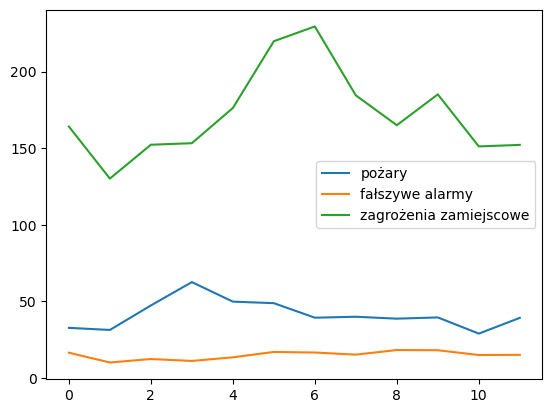

In [14]:
plt.plot(srednia_miesieczna, label='pożary')
plt.plot(srednia_miesieczna_falsz, label='fałszywe alarmy')
plt.plot(srednia_miesieczna_zagr, label='zagrożenia zamiejscowe')
plt.legend()
plt.show()

In [15]:
miech = df.groupby('miesiac').mean()
miech

,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem
miesiac,,,,
01,16.375000,164.125000,32.625000,213.125000
02,10.000000,130.125000,31.250000,171.375000
03,12.250000,152.250000,47.250000,211.750000
04,11.000000,153.250000,62.500000,226.750000
05,13.375000,176.250000,49.750000,239.375000
06,16.875000,219.875000,48.750000,285.500000
07,16.500000,229.500000,39.250000,285.250000
08,15.125000,184.500000,39.875000,239.500000
09,18.125000,165.000000,38.625000,221.750000


array([<AxesSubplot: xlabel='miesiac'>, <AxesSubplot: xlabel='miesiac'>,
       <AxesSubplot: xlabel='miesiac'>, <AxesSubplot: xlabel='miesiac'>],
      dtype=object)

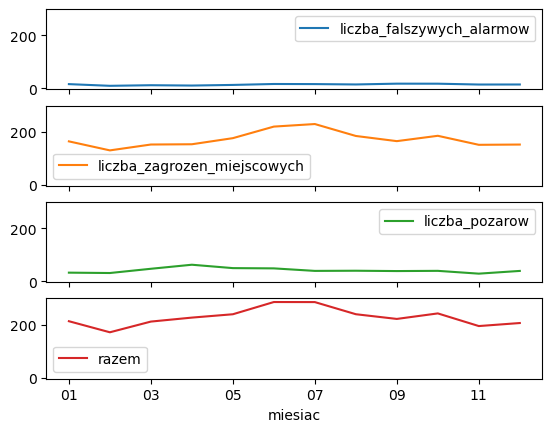

In [16]:
miech.plot(subplots= True, sharey=True)

In [17]:
df.groupby('rok').mean()

,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem
rok,,,,
2015,9.916667,138.166667,50.833333,198.916667
2016,9.750000,162.916667,42.583333,215.250000
2017,14.916667,173.500000,45.750000,234.166667
2018,19.083333,157.666667,49.083333,225.833333
2019,14.583333,143.250000,38.750000,196.583333
2020,17.333333,240.750000,32.750000,290.833333
2021,17.333333,177.583333,30.500000,225.416667
2022,15.222222,188.000000,43.111111,246.333333


# Pobranie danych pogodowych

# Dane pobrane z wykorzystaniem narzędzia selenium. Kod dostępny na: https://github.com/KrzysztofSolowiej/public_projects/blob/main/Fire_vs_Weather_Project/

In [18]:
weather = pd.read_csv('https://github.com/KrzysztofSolowiej/public_projects/blob/main/Fire_vs_Weather_Project/full_weather_data.csv?raw=true')
weather_df = pd.DataFrame(weather)
weather_df

,Month,Year,avr_temp_F,max_temp_F,min_temp_F,avr_wind_mph,avr_press_inch
0,1,2015,33.95,48,18,10.27,29.29
1,2,2015,33.55,48,12,7.99,29.46
2,3,2015,39.99,63,27,8.33,29.57
3,4,2015,44.65,72,28,11.31,29.47
4,5,2015,51.96,73,36,8.32,29.44
...,...,...,...,...,...,...,...
88,5,2022,52.40,79,32,9.65,29.51
89,6,2022,62.24,88,43,8.29,29.50
90,7,2022,63.82,93,50,10.09,29.53
91,8,2022,68.11,91,50,7.42,29.56


In [19]:
weather_df.columns

Index(['Month', ' Year', ' avr_temp_F', ' max_temp_F', ' min_temp_F',
       ' avr_wind_mph', ' avr_press_inch'],
      dtype='object')

In [20]:
col_dict = {'Month':'weather_month',' Year':'weather_year',' avr_temp_F':'avr_temp_F',' max_temp_F':'max_temp_F',' min_temp_F':'min_temp_F',' avr_wind_mph':'avr_wind_mph', ' avr_press_inch':'avr_press_inch'}
weather_df = weather_df.rename(columns=col_dict)

In [21]:
weather_df['data'] = weather_df['weather_month'].astype('str') + '-' + weather_df['weather_year'].astype('str')
weather_df['data'] = pd.to_datetime(weather_df['data'], format='%m-%Y')

In [22]:
weather_df

,weather_month,weather_year,avr_temp_F,max_temp_F,min_temp_F,avr_wind_mph,avr_press_inch,data
0,1,2015,33.95,48,18,10.27,29.29,2015-01-01
1,2,2015,33.55,48,12,7.99,29.46,2015-02-01
2,3,2015,39.99,63,27,8.33,29.57,2015-03-01
3,4,2015,44.65,72,28,11.31,29.47,2015-04-01
4,5,2015,51.96,73,36,8.32,29.44,2015-05-01
...,...,...,...,...,...,...,...,...
88,5,2022,52.40,79,32,9.65,29.51,2022-05-01
89,6,2022,62.24,88,43,8.29,29.50,2022-06-01
90,7,2022,63.82,93,50,10.09,29.53,2022-07-01
91,8,2022,68.11,91,50,7.42,29.56,2022-08-01


In [23]:
df

,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem,data,rok,miesiac
0,12,172,28,212,2015-01-01,2015,01
1,11,92,39,142,2015-02-01,2015,02
2,10,110,66,186,2015-03-01,2015,03
3,8,114,65,187,2015-04-01,2015,04
4,10,141,57,208,2015-05-01,2015,05
...,...,...,...,...,...,...,...
88,15,211,31,257,2021-11-01,2021,11
89,17,158,30,205,2021-12-01,2021,12
90,30,363,40,433,2022-01-01,2022,01
91,15,182,29,226,2022-02-01,2022,02


# Połączenie zebranych danych w ramach jednego DataFrame

In [24]:
full_df = weather_df.merge(df, on='data')
full_df.drop(columns=['weather_month', 'weather_year'], inplace=True)
full_df

,avr_temp_F,max_temp_F,min_temp_F,avr_wind_mph,avr_press_inch,data,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem,rok,miesiac
0,33.95,48,18,10.27,29.29,2015-01-01,12,172,28,212,2015,01
1,33.55,48,12,7.99,29.46,2015-02-01,11,92,39,142,2015,02
2,39.99,63,27,8.33,29.57,2015-03-01,10,110,66,186,2015,03
3,44.65,72,28,11.31,29.47,2015-04-01,8,114,65,187,2015,04
4,51.96,73,36,8.32,29.44,2015-05-01,10,141,57,208,2015,05
...,...,...,...,...,...,...,...,...,...,...,...,...
88,52.40,79,32,9.65,29.51,2022-05-01,14,128,63,205,2022,05
89,62.24,88,43,8.29,29.50,2022-06-01,16,178,36,230,2022,06
90,63.82,93,50,10.09,29.53,2022-07-01,14,183,27,224,2022,07
91,68.11,91,50,7.42,29.56,2022-08-01,16,216,37,269,2022,08


In [25]:
full_df.dtypes

avr_temp_F                            float64
max_temp_F                              int64
min_temp_F                              int64
avr_wind_mph                          float64
avr_press_inch                        float64
data                           datetime64[ns]
liczba_falszywych_alarmow               int64
liczba_zagrozen_miejscowych             int64
liczba_pozarow                          int64
razem                                   int64
rok                                    object
miesiac                                object
dtype: object

# Zamiana jednostek

In [26]:
full_df['avr_temp_C'] = round(((full_df.avr_temp_F - 32)*(5/9)), 2)
full_df['max_temp_C'] = round(((full_df.max_temp_F - 32)*(5/9)), 2)
full_df['min_temp_C'] = round(((full_df.min_temp_F - 32)*(5/9)), 2)
full_df['avr_wind_kmh'] = round((full_df.avr_wind_mph * 1.60934),2)
full_df['avr_press_hPa'] = round((full_df.avr_press_inch * 33.863886666667),2)
full_df

,avr_temp_F,max_temp_F,min_temp_F,avr_wind_mph,avr_press_inch,data,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem,rok,miesiac,avr_temp_C,max_temp_C,min_temp_C,avr_wind_kmh,avr_press_hPa
0,33.95,48,18,10.27,29.29,2015-01-01,12,172,28,212,2015,01,1.08,8.89,-7.78,16.53,991.87
1,33.55,48,12,7.99,29.46,2015-02-01,11,92,39,142,2015,02,0.86,8.89,-11.11,12.86,997.63
2,39.99,63,27,8.33,29.57,2015-03-01,10,110,66,186,2015,03,4.44,17.22,-2.78,13.41,1001.36
3,44.65,72,28,11.31,29.47,2015-04-01,8,114,65,187,2015,04,7.03,22.22,-2.22,18.20,997.97
4,51.96,73,36,8.32,29.44,2015-05-01,10,141,57,208,2015,05,11.09,22.78,2.22,13.39,996.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,52.40,79,32,9.65,29.51,2022-05-01,14,128,63,205,2022,05,11.33,26.11,0.00,15.53,999.32
89,62.24,88,43,8.29,29.50,2022-06-01,16,178,36,230,2022,06,16.80,31.11,6.11,13.34,998.98
90,63.82,93,50,10.09,29.53,2022-07-01,14,183,27,224,2022,07,17.68,33.89,10.00,16.24,1000.00
91,68.11,91,50,7.42,29.56,2022-08-01,16,216,37,269,2022,08,20.06,32.78,10.00,11.94,1001.02


# Usuwanie niepotrzebnych kolumn

In [27]:
full_df.drop(columns=['avr_temp_F', 'max_temp_F', 'min_temp_F', 'avr_wind_mph', 'avr_press_inch'], inplace=True)

In [28]:
full_df

,data,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem,rok,miesiac,avr_temp_C,max_temp_C,min_temp_C,avr_wind_kmh,avr_press_hPa
0,2015-01-01,12,172,28,212,2015,01,1.08,8.89,-7.78,16.53,991.87
1,2015-02-01,11,92,39,142,2015,02,0.86,8.89,-11.11,12.86,997.63
2,2015-03-01,10,110,66,186,2015,03,4.44,17.22,-2.78,13.41,1001.36
3,2015-04-01,8,114,65,187,2015,04,7.03,22.22,-2.22,18.20,997.97
4,2015-05-01,10,141,57,208,2015,05,11.09,22.78,2.22,13.39,996.95
...,...,...,...,...,...,...,...,...,...,...,...,...
88,2022-05-01,14,128,63,205,2022,05,11.33,26.11,0.00,15.53,999.32
89,2022-06-01,16,178,36,230,2022,06,16.80,31.11,6.11,13.34,998.98
90,2022-07-01,14,183,27,224,2022,07,17.68,33.89,10.00,16.24,1000.00
91,2022-08-01,16,216,37,269,2022,08,20.06,32.78,10.00,11.94,1001.02


# Sprawdzenie czy dane odpowiadają rozkładowi normalnemu

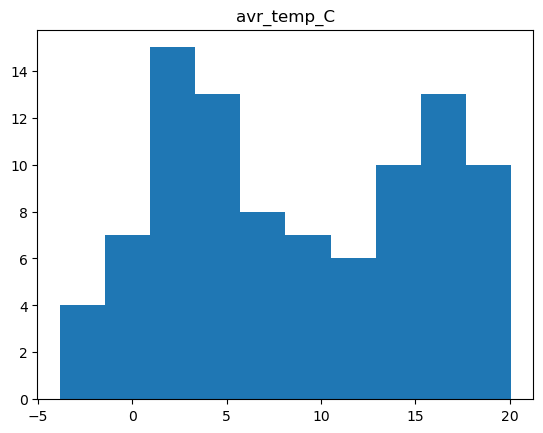

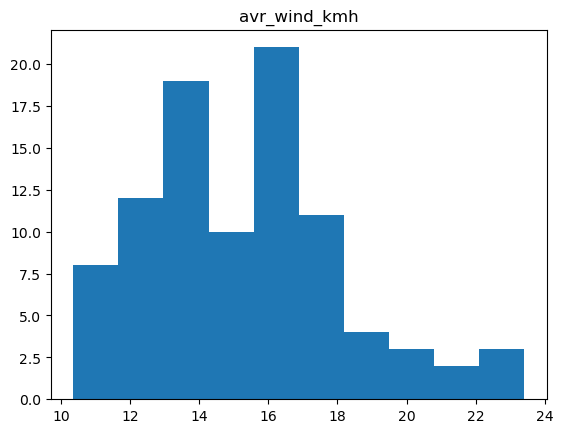

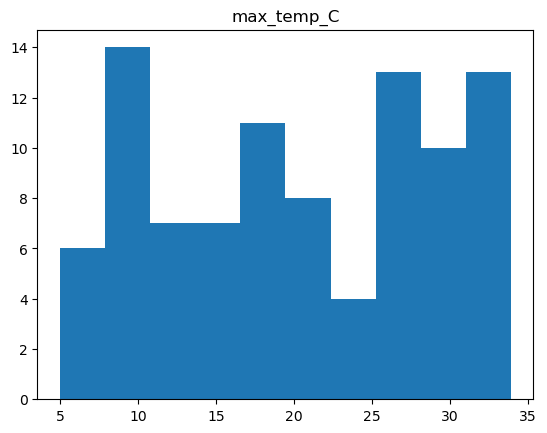

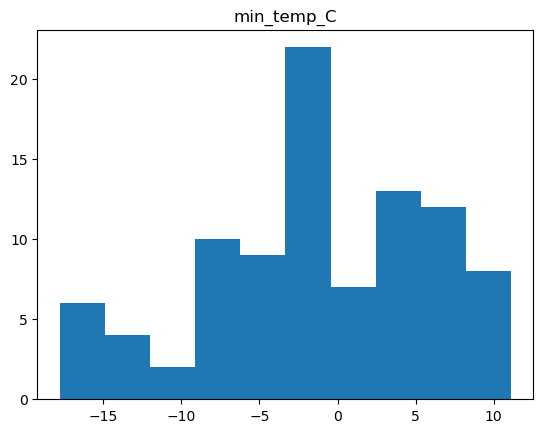

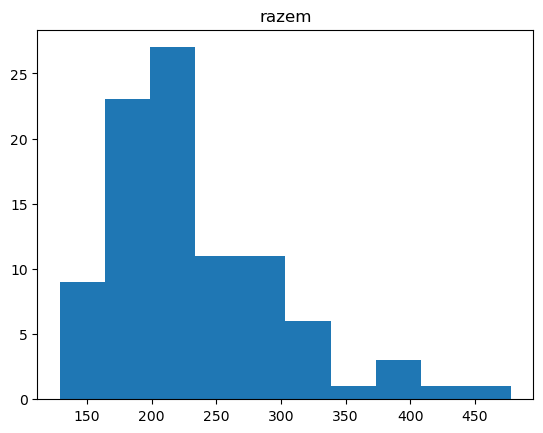

In [29]:
cols = ['avr_temp_C', 'avr_wind_kmh', 'max_temp_C', 'min_temp_C', 'razem']
for i in cols:
    plt.hist(full_df[i])
    plt.title(i)
    plt.show()

count    93.000000
mean     21.624731
std       4.508485
min      11.670000
25%      18.330000
50%      22.220000
75%      24.440000
max      35.560000
Name: temp_diff, dtype: float64


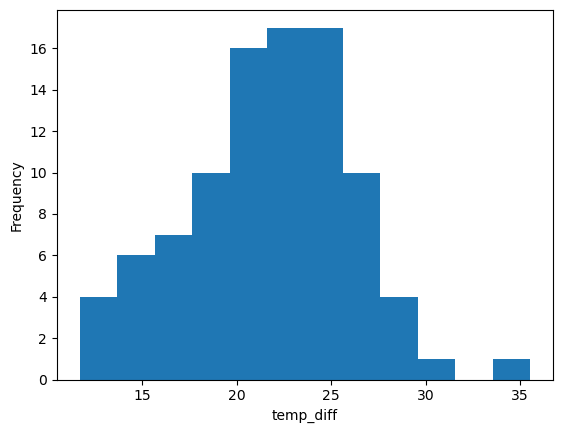

In [30]:
full_df['temp_diff'] = full_df['max_temp_C'] - full_df['min_temp_C']
print(full_df['temp_diff'].describe())
full_df['temp_diff'].plot(kind='hist', bins=12)
plt.xlabel('temp_diff')
plt.show()

# Wizualizacja łącznej liczby interwencji straży pożarnej w poszczególnych miesiącach lat 2015-2022

In [31]:
pivot = full_df.pivot_table(index='miesiac', columns='rok', values='razem')
pivot

rok,2015,2016,2017,2018,2019,2020,2021,2022
miesiac,,,,,,,,
01,212.0,172.0,160.0,182.0,200.0,165.0,181.0,433.0
02,142.0,129.0,165.0,161.0,172.0,211.0,165.0,226.0
03,186.0,146.0,200.0,202.0,219.0,360.0,188.0,193.0
04,187.0,175.0,200.0,214.0,235.0,400.0,176.0,227.0
05,208.0,241.0,246.0,227.0,210.0,388.0,190.0,205.0
06,212.0,278.0,269.0,276.0,331.0,379.0,309.0,230.0
07,220.0,478.0,332.0,320.0,148.0,276.0,284.0,224.0
08,221.0,215.0,295.0,254.0,135.0,289.0,238.0,269.0
09,185.0,178.0,234.0,272.0,139.0,304.0,252.0,210.0


Text(0.5, 1.0, '2022')

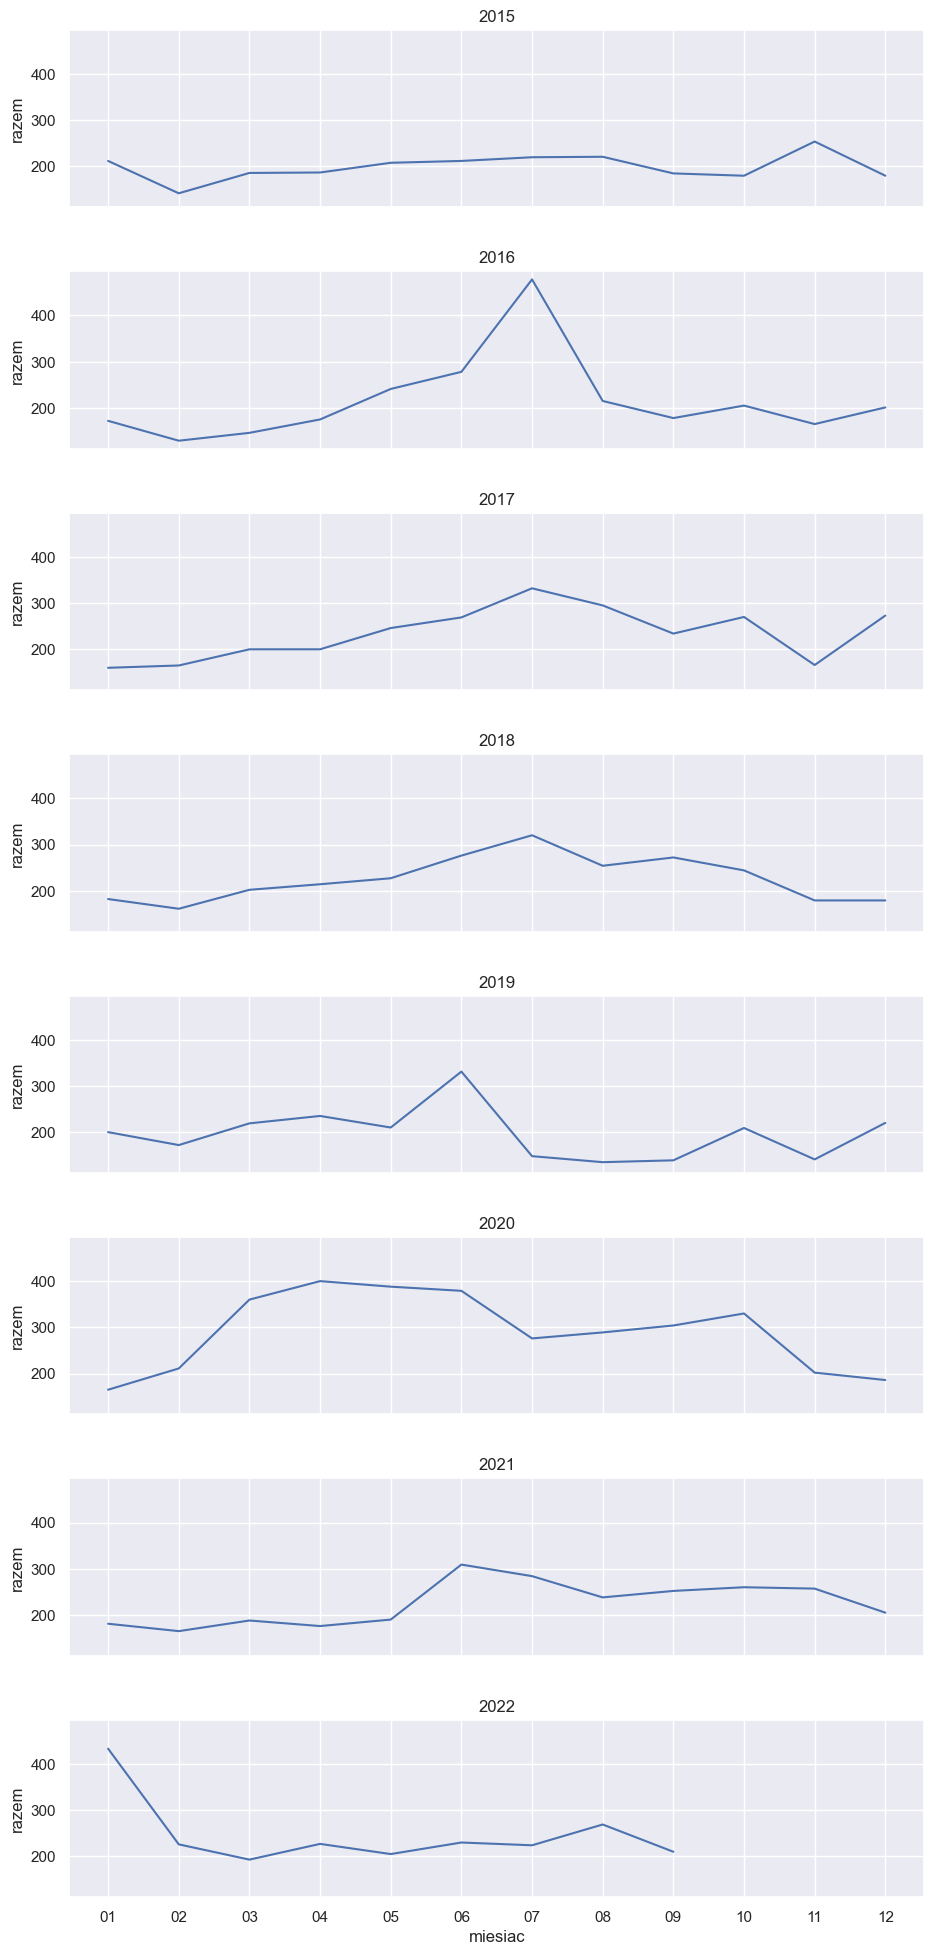

In [32]:
sns.set(rc={"figure.figsize":(10, 20)})
fig, ax = plt.subplots(8, sharex=True, sharey=True)
fig.tight_layout(pad=3.0)

sns.set(style="ticks")
g1 = sns.lineplot(x="miesiac", y=full_df[full_df['rok'] == '2015']['razem'], data=full_df, ax=ax[0])
g2 = sns.lineplot(x="miesiac", y=full_df[full_df['rok'] == '2016']['razem'], data=full_df, ax=ax[1])
g3 = sns.lineplot(x="miesiac", y=full_df[full_df['rok'] == '2017']['razem'], data=full_df, ax=ax[2])
g4 = sns.lineplot(x="miesiac", y=full_df[full_df['rok'] == '2018']['razem'], data=full_df, ax=ax[3])
g5 = sns.lineplot(x="miesiac", y=full_df[full_df['rok'] == '2019']['razem'], data=full_df, ax=ax[4])
g6 = sns.lineplot(x="miesiac", y=full_df[full_df['rok'] == '2020']['razem'], data=full_df, ax=ax[5])
g7 = sns.lineplot(x="miesiac", y=full_df[full_df['rok'] == '2021']['razem'], data=full_df, ax=ax[6])
g8 = sns.lineplot(x="miesiac", y=full_df[full_df['rok'] == '2022']['razem'], data=full_df, ax=ax[7])

g1.set_title('2015')
g2.set_title('2016')
g3.set_title('2017')
g4.set_title('2018')
g5.set_title('2019')
g6.set_title('2020')
g7.set_title('2021')
g8.set_title('2022')


# Wstępna wizualizacja potencjalnych korelacji

Text(0.5, 1.0, 'Średnia miesięczna ilość interwencji straży pożarnej w latach 2015-2022')

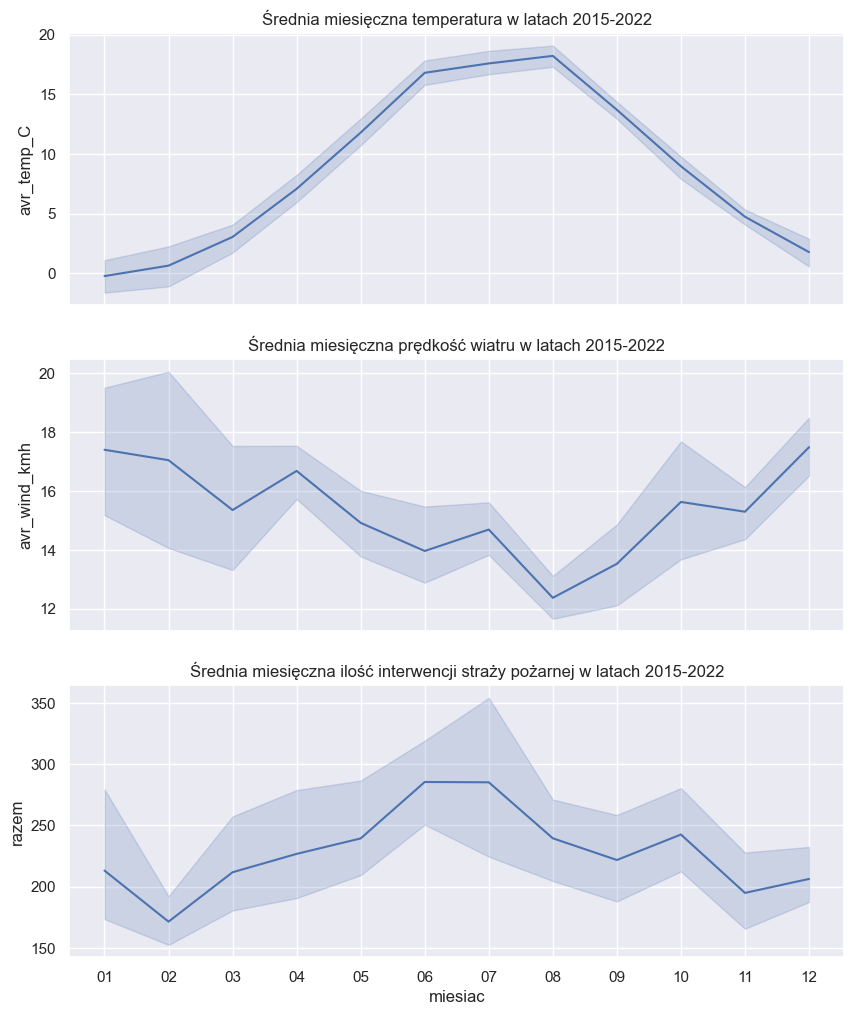

In [33]:
sns.set(rc={"figure.figsize":(10, 12)})
fig, ax = plt.subplots(3, sharex=True)

sns.set(style="ticks")
g1 = sns.lineplot(x="miesiac", y='avr_temp_C', data=full_df, ax=ax[0])
g2 = sns.lineplot(x="miesiac", y='avr_wind_kmh', data=full_df, ax=ax[1])
g3 = sns.lineplot(x="miesiac", y='razem', data=full_df, ax=ax[2])

g1.set_title('Średnia miesięczna temperatura w latach 2015-2022')
g2.set_title('Średnia miesięczna prędkość wiatru w latach 2015-2022')
g3.set_title('Średnia miesięczna ilość interwencji straży pożarnej w latach 2015-2022')

Text(0.5, 1.0, 'Średnia miesięczna ilość interwencji straży pożarnej w latach 2015-2022')

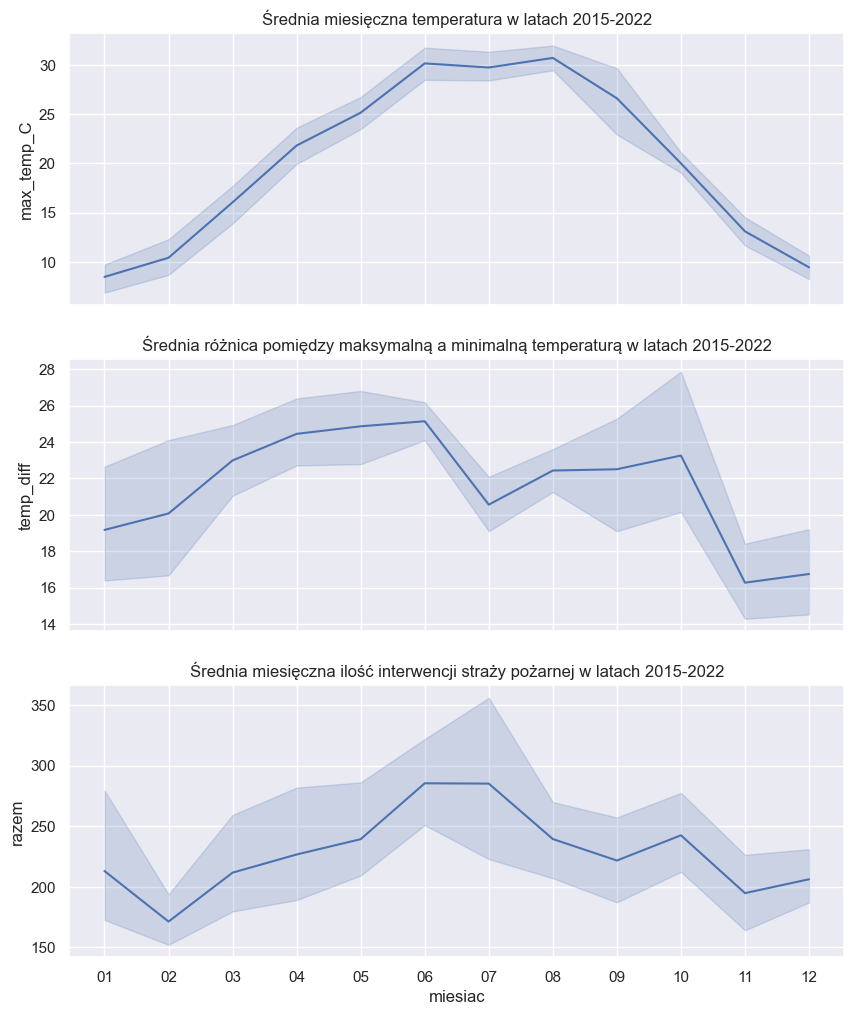

In [34]:
sns.set(rc={"figure.figsize":(10, 12)})
fig, ax = plt.subplots(3, sharex=True)

sns.set(style="ticks")
g1 = sns.lineplot(x="miesiac", y='max_temp_C', data=full_df, ax=ax[0])
g2 = sns.lineplot(x="miesiac", y='temp_diff', data=full_df, ax=ax[1])
g3 = sns.lineplot(x="miesiac", y='razem', data=full_df, ax=ax[2])

g1.set_title('Średnia miesięczna temperatura w latach 2015-2022')
g2.set_title('Średnia różnica pomiędzy maksymalną a minimalną temperaturą w latach 2015-2022')
g3.set_title('Średnia miesięczna ilość interwencji straży pożarnej w latach 2015-2022')

Text(0.5, 1.0, 'Średnia roczna ilość interwencji w latach 2015-2022')

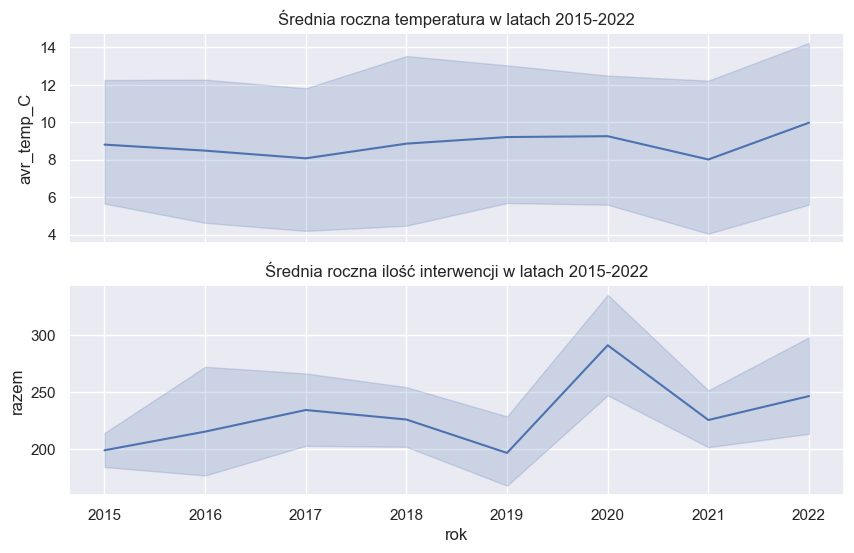

In [35]:
sns.set(rc={"figure.figsize":(10, 6)})
fig, ax = plt.subplots(2, sharex=True)

sns.set(style="ticks")
g1 = sns.lineplot(x="rok", y='avr_temp_C', data=full_df, ax=ax[0])
g2 = sns.lineplot(x="rok", y='razem', data=full_df, ax=ax[1])

g1.set_title('Średnia roczna temperatura w latach 2015-2022')
g2.set_title('Średnia roczna ilość interwencji w latach 2015-2022')

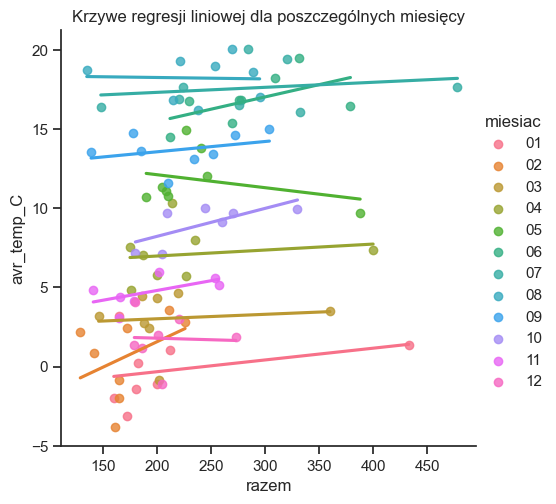

In [36]:
sns.lmplot(x='razem', y='avr_temp_C', data=full_df, hue='miesiac', palette='husl', ci=None)
plt.title('Krzywe regresji liniowej dla poszczególnych miesięcy')
plt.show()

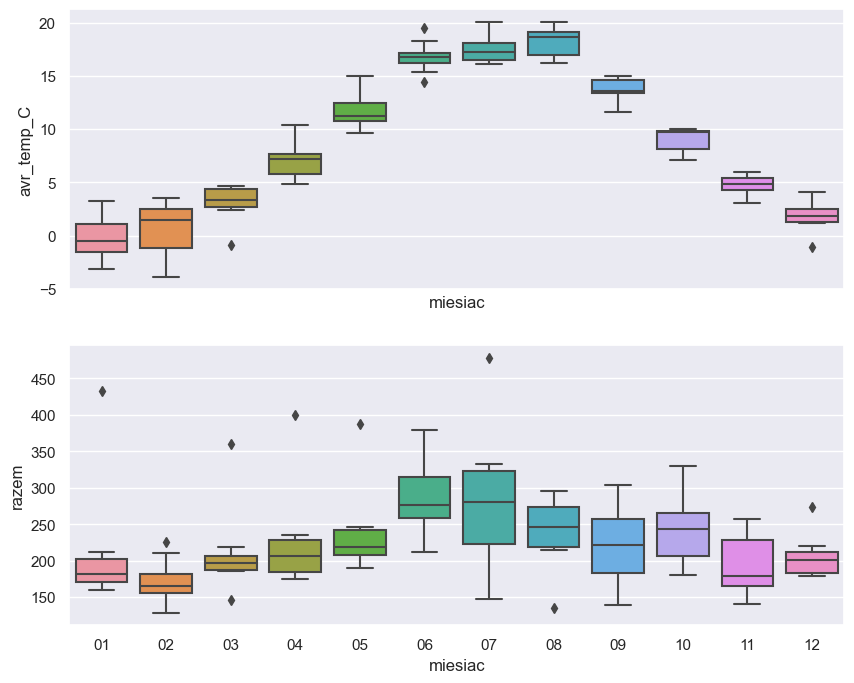

In [37]:
sns.set(rc={"figure.figsize":(10, 8)})
fig, ax = plt.subplots(2, sharex=True)
g1 = sns.boxplot(x='miesiac', y='avr_temp_C', data=full_df, ax=ax[0])
g2 = sns.boxplot(x='miesiac', y='razem', data=full_df, ax=ax[1])
plt.show()

# Identyfikacja najbardziej wpływowych cech

In [38]:
X = full_df.drop(['razem', 'data','liczba_falszywych_alarmow','liczba_zagrozen_miejscowych','liczba_pozarow'], axis=1).values
y = full_df['razem'].values
names = full_df.drop(['razem', 'data','liczba_falszywych_alarmow','liczba_zagrozen_miejscowych','liczba_pozarow'], axis=1).columns

In [39]:
lasso = Lasso(alpha=1.0)
lasso_coef = lasso.fit(X,y).coef_

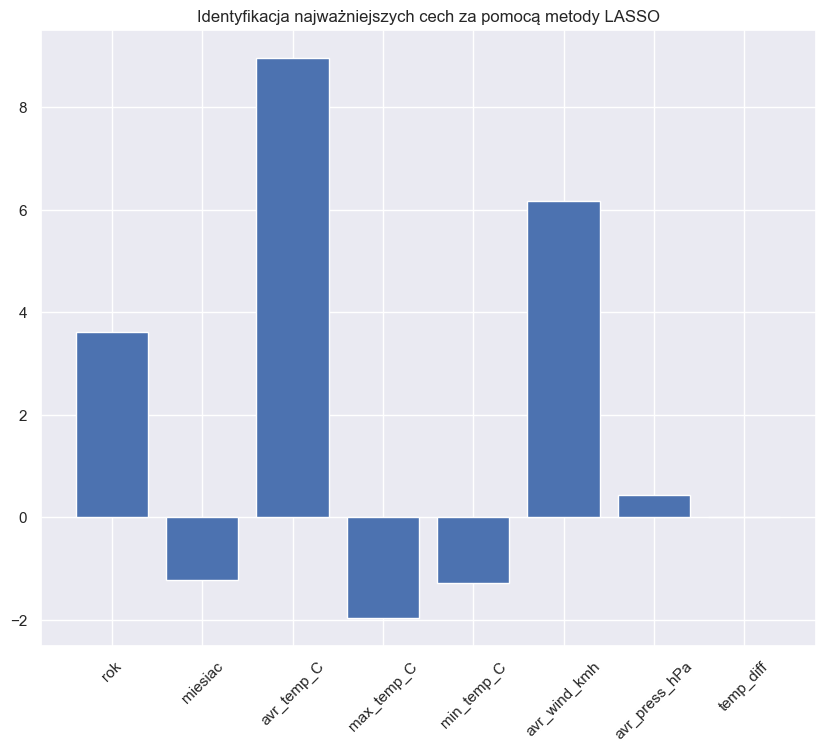

In [40]:
plt.bar(names, lasso_coef)
plt.xticks(rotation=45)
plt.title('Identyfikacja najważniejszych cech za pomocą metody LASSO')
plt.show()

# Zobrazowanie korelacji

In [41]:
cols = ['avr_temp_C', 'avr_wind_kmh', 'max_temp_C', 'min_temp_C', 'razem']
full_df[cols].corr()

,avr_temp_C,avr_wind_kmh,max_temp_C,min_temp_C,razem
avr_temp_C,1.000000,-0.420848,0.942104,0.933419,0.424198
avr_wind_kmh,-0.420848,1.000000,-0.446868,-0.318049,0.069858
max_temp_C,0.942104,-0.446868,1.000000,0.849110,0.367681
min_temp_C,0.933419,-0.318049,0.849110,1.000000,0.400116
razem,0.424198,0.069858,0.367681,0.400116,1.000000


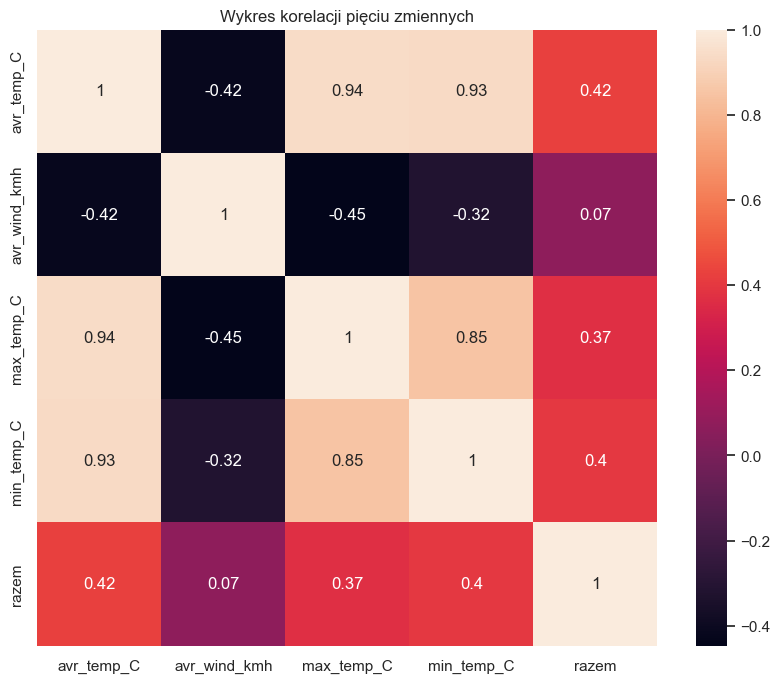

In [42]:
sns.heatmap(full_df[cols].corr(), annot=True)
plt.title('Wykres korelacji pięciu zmiennych')
plt.show()

# W stosunku do liczby interwencji straży pożarnej, siła wiatru wykazuje zerową korelację. Z kolei, atrybuty związane z temperaturą wykazują umiarkowaną pozytywną korelację.

array([[<AxesSubplot: xlabel='avr_temp_C', ylabel='avr_temp_C'>,
        <AxesSubplot: xlabel='avr_wind_kmh', ylabel='avr_temp_C'>,
        <AxesSubplot: xlabel='max_temp_C', ylabel='avr_temp_C'>,
        <AxesSubplot: xlabel='min_temp_C', ylabel='avr_temp_C'>,
        <AxesSubplot: xlabel='razem', ylabel='avr_temp_C'>],
       [<AxesSubplot: xlabel='avr_temp_C', ylabel='avr_wind_kmh'>,
        <AxesSubplot: xlabel='avr_wind_kmh', ylabel='avr_wind_kmh'>,
        <AxesSubplot: xlabel='max_temp_C', ylabel='avr_wind_kmh'>,
        <AxesSubplot: xlabel='min_temp_C', ylabel='avr_wind_kmh'>,
        <AxesSubplot: xlabel='razem', ylabel='avr_wind_kmh'>],
       [<AxesSubplot: xlabel='avr_temp_C', ylabel='max_temp_C'>,
        <AxesSubplot: xlabel='avr_wind_kmh', ylabel='max_temp_C'>,
        <AxesSubplot: xlabel='max_temp_C', ylabel='max_temp_C'>,
        <AxesSubplot: xlabel='min_temp_C', ylabel='max_temp_C'>,
        <AxesSubplot: xlabel='razem', ylabel='max_temp_C'>],
       [<AxesSubplot:

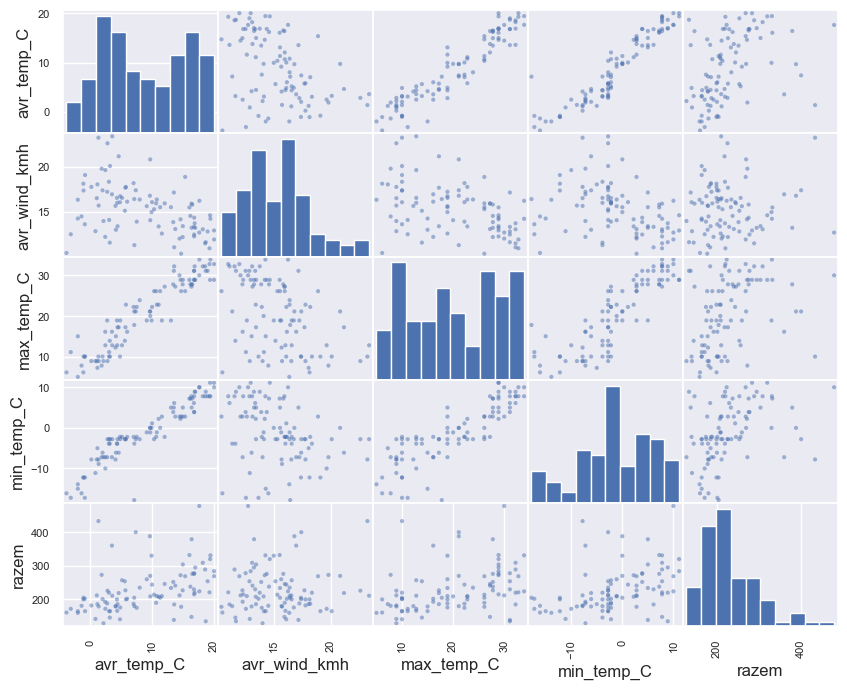

In [43]:
pd.plotting.scatter_matrix(full_df[cols])

# Dystrybucja zmiennej 'razem' sugeruje zastosowanie transformacji logarytmicznej

# Wizualizacja zauważonego trendu

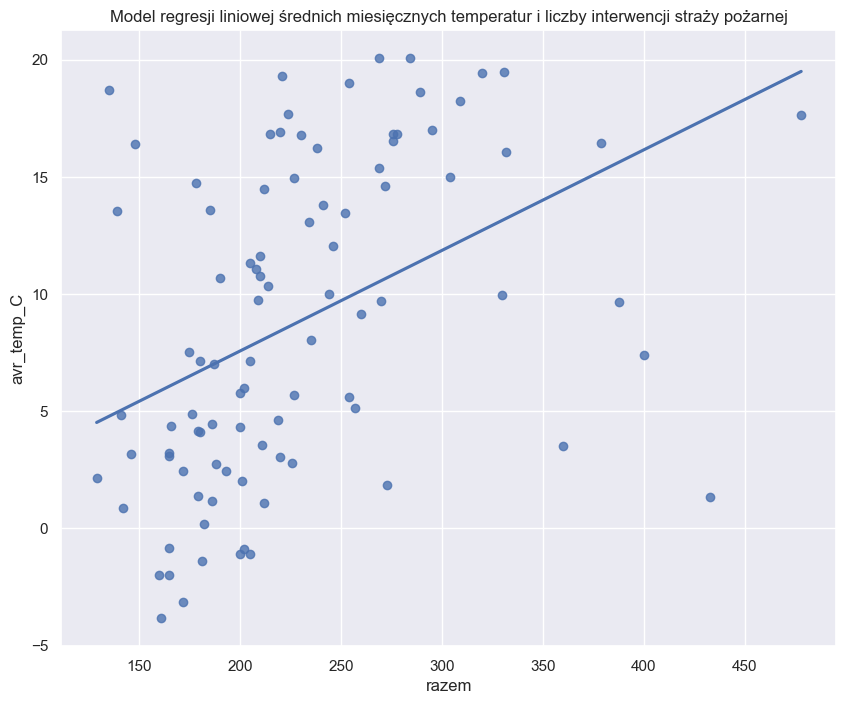

In [44]:
sns.regplot(x='razem', y='avr_temp_C', data=full_df, ci=None)
plt.title('Model regresji liniowej średnich miesięcznych temperatur i liczby interwencji straży pożarnej')
plt.show()

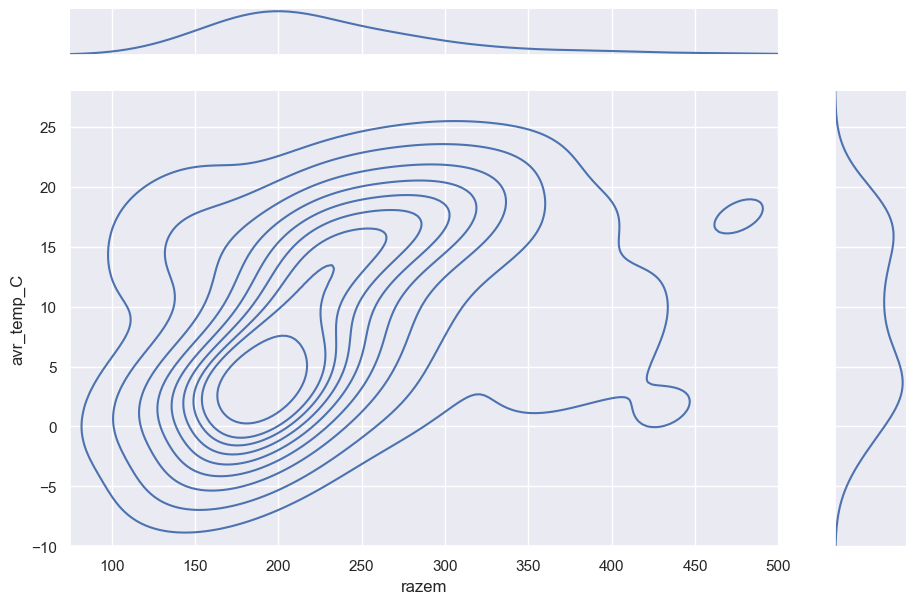

In [45]:
grid = sns.jointplot(x='razem', y='avr_temp_C', data=full_df, kind="kde", space=0.8, ratio=6, height=8, ylim=(-10, 28), xlim=(75, 500))
grid.fig.set_figwidth(9.5)
grid.fig.set_figheight(6)
plt.show()

# Próba predykcji

In [46]:
avr_temp_vs_razem = smf.ols(formula='avr_temp_C ~ razem', data=full_df)
avr_temp_vs_razem = avr_temp_vs_razem.fit()
print(avr_temp_vs_razem.resid)
avr_temp_vs_razem.summary()
#Nie jestem pewien czy otrzymane wartości odpowiadają danym. Czy potrzebna jest standaryzacja atrybutów?

0    -7.004118
1    -4.220369
2    -2.528440
3     0.018649
4     3.177525
        ...   
88    3.546257
89    7.943489
90    9.080954
91    9.529972
92    3.611703
Length: 93, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avr_temp_C   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     19.97
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           2.26e-05
Time:                        14:17:28   Log-Likelihood:                -300.57
No. Observations:                  93   AIC:                             605.1
Df Residuals:                      91   BIC:                             610.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0129      2.287     -0.443      0.659      -5.557       3.531
razem          0.0429      0.010      4.469      0.000       0.024       0.062
==============================================================================
Omnibus:                        3.596   Durbin-Watson:                   0.478
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                1.995
Skew:                          -0.007   Prob(JB):                        0.369
Kurtosis:                       2.283   Cond. No.                         848.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
expl_data = pd.DataFrame({'razem' : np.arange(1,600,10)})
prediction_data = expl_data.assign(temp_pred=avr_temp_vs_razem.predict(expl_data))
prediction_data

,razem,temp_pred
0,1,-0.970039
1,11,-0.540932
2,21,-0.111825
3,31,0.317282
4,41,0.746389
5,51,1.175496
6,61,1.604603
7,71,2.033710
8,81,2.462817
9,91,2.891924


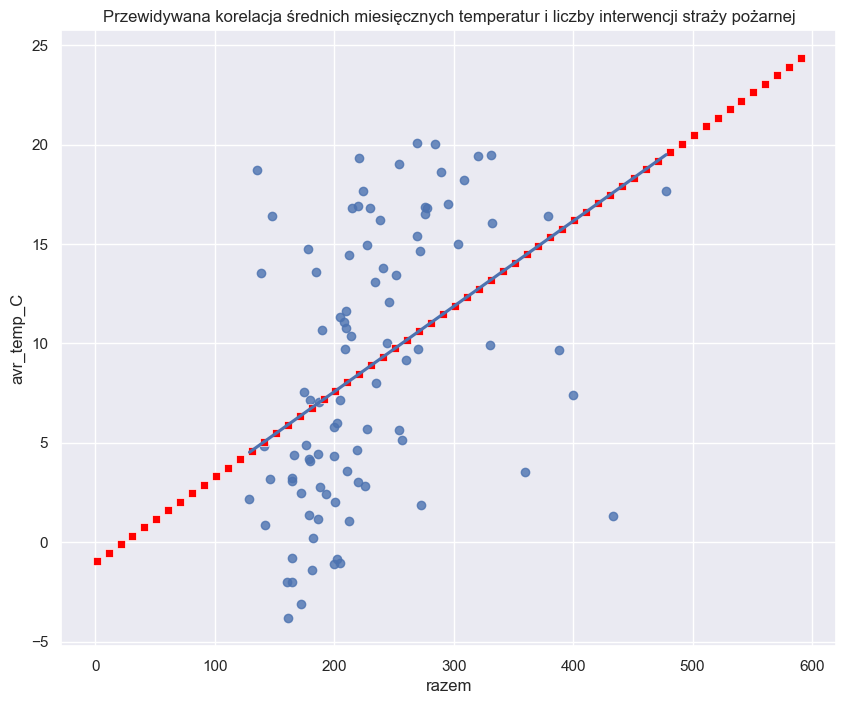

In [48]:
fig = plt.figure()
sns.regplot(x='razem', y='avr_temp_C', data=full_df, ci=None).set_title('Przewidywana korelacja średnich miesięcznych temperatur i liczby interwencji straży pożarnej')
sns.scatterplot(x='razem', y='temp_pred', data=prediction_data, color='red', marker='s')
plt.show()

# Wykresy diagnostyczne

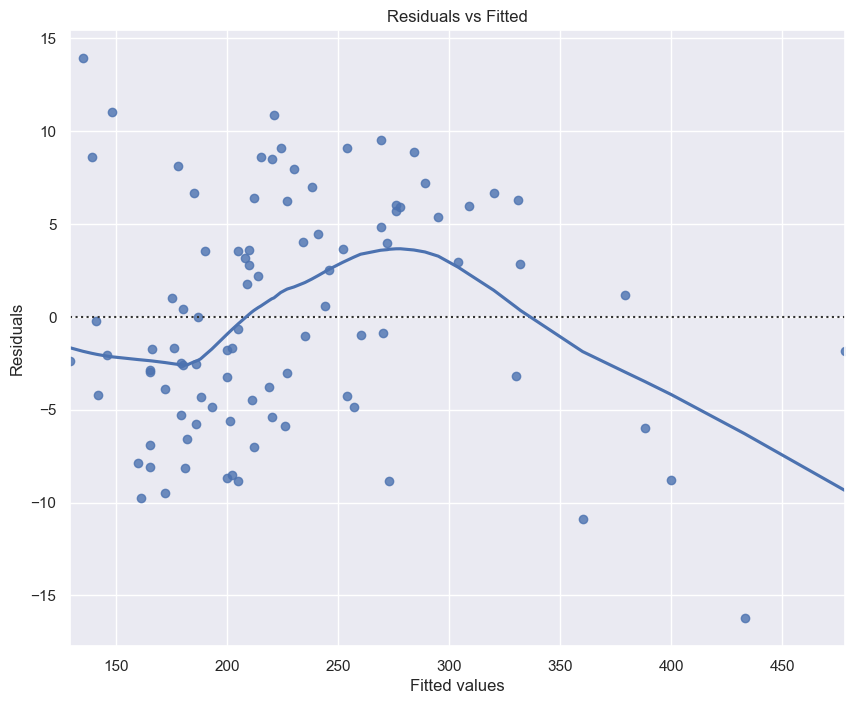

In [49]:
sns.residplot(x='razem', y='avr_temp_C', data=full_df, lowess=True)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

Text(0.5, 1.0, 'Normal Q-Q')

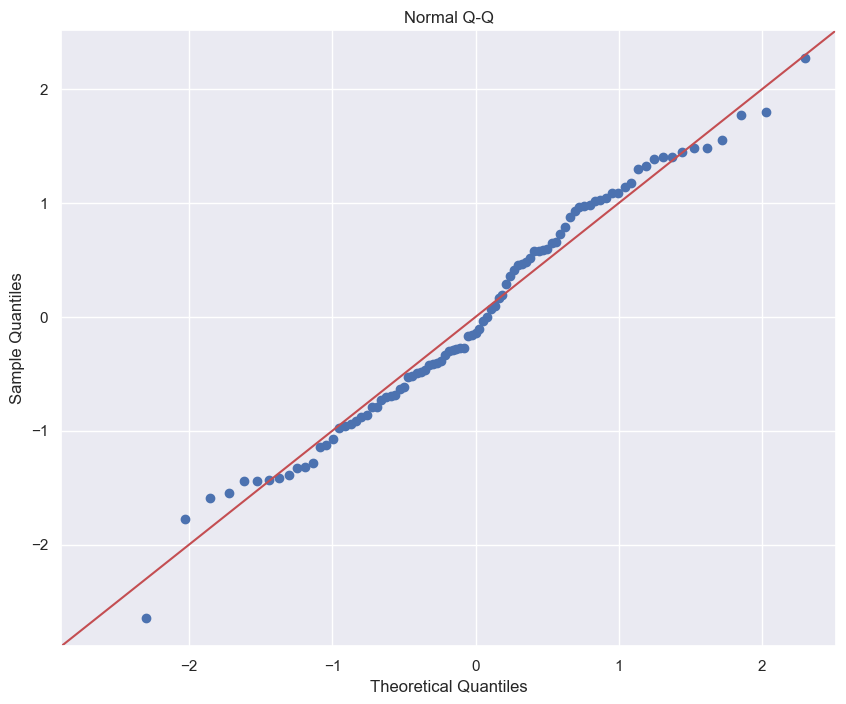

In [50]:
qqplot(data=avr_temp_vs_razem.resid, fit=True, line='45')
plt.title('Normal Q-Q')

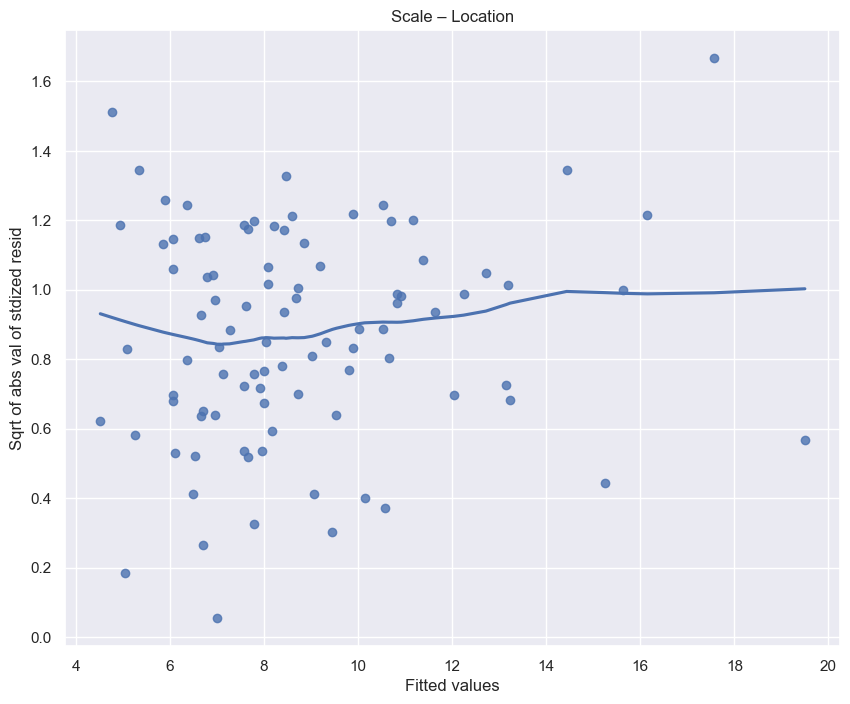

In [51]:
model_normal_resid = avr_temp_vs_razem.get_influence().resid_studentized_internal
model_normal_abs_sqrt = np.sqrt(np.abs(model_normal_resid))
sns.regplot(x=avr_temp_vs_razem.fittedvalues, y=model_normal_abs_sqrt, ci=None, lowess=True)
plt.title('Scale – Location')
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of abs val of stdized resid')
plt.show()

# Wykrycie i usunięcie najbardziej wpływowej obserwacji

In [52]:
summary_model = avr_temp_vs_razem.get_influence().summary_frame()
full_df['leverage'] = summary_model['hat_diag']
full_df['cooks_dist'] = summary_model['cooks_d']
full_df.sort_values('cooks_dist', ascending=False)

,data,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem,rok,miesiac,avr_temp_C,max_temp_C,min_temp_C,avr_wind_kmh,avr_press_hPa,temp_diff,leverage,cooks_dist
84,2022-01-01,30,363,40,433,2022,01,1.34,10.00,-7.78,23.25,996.28,17.78,0.111095,4.822045e-01
63,2020-04-01,10,326,64,400,2020,04,7.38,21.11,-2.78,17.41,1000.00,23.89,0.081309,9.653361e-02
62,2020-03-01,21,315,24,360,2020,03,3.53,16.11,-7.22,16.96,999.66,23.33,0.052218,9.003168e-02
55,2019-08-01,23,81,31,135,2019,08,18.71,31.11,8.89,11.64,999.66,22.22,0.031803,8.574067e-02
54,2019-07-01,15,91,42,148,2019,07,16.40,27.22,7.78,15.92,995.94,19.44,0.026362,4.432166e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,2016-10-01,12,167,26,205,2016,10,7.13,17.78,-17.78,16.43,1004.40,35.56,0.012092,6.896515e-05
45,2018-10-01,18,181,45,244,2018,10,10.02,22.22,1.11,16.09,998.98,21.11,0.011321,4.777007e-05
9,2015-10-01,6,121,53,180,2015,10,7.15,21.11,-3.89,11.31,1005.08,25.00,0.016429,4.263168e-05
58,2019-11-01,17,107,17,141,2019,11,4.83,10.00,-2.22,16.08,991.20,12.22,0.029191,1.736161e-05


<AxesSubplot: title={'center': 'Dane bez wiersza z wartością ekstremalną'}, xlabel='razem', ylabel='avr_temp_C'>

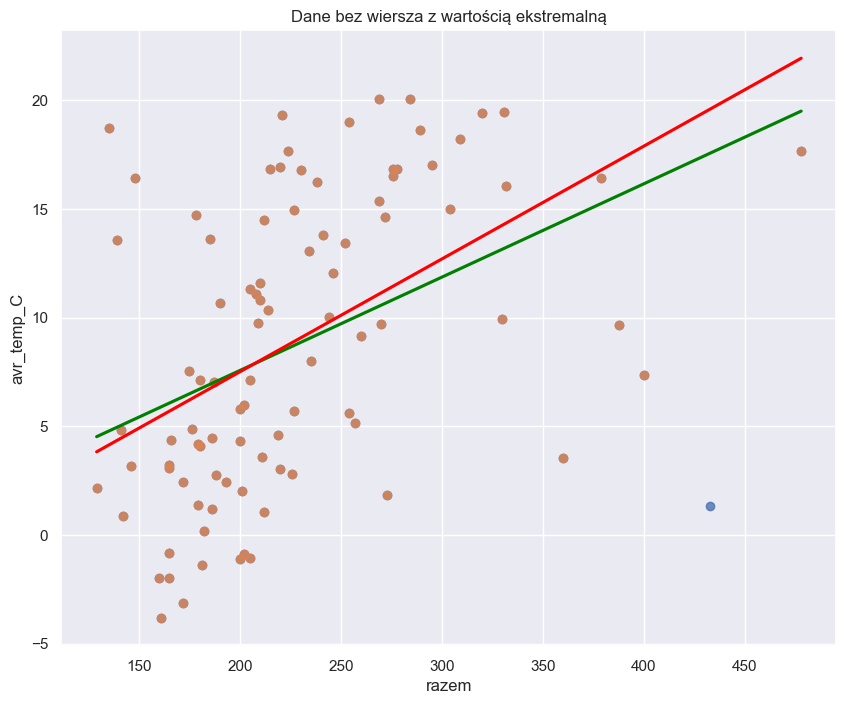

In [53]:
full_df_edit = full_df[full_df['razem'] != 433]
sns.regplot(x='razem', y='avr_temp_C', data=full_df, ci=None, line_kws={'color':'green'}).set_title('Dane bez wiersza z wartością ekstremalną')
sns.regplot(x='razem', y='avr_temp_C', data=full_df_edit, ci=None, line_kws={'color':'red'})

# Transformacja zmiennych

Text(0.5, 1.0, 'log razem')

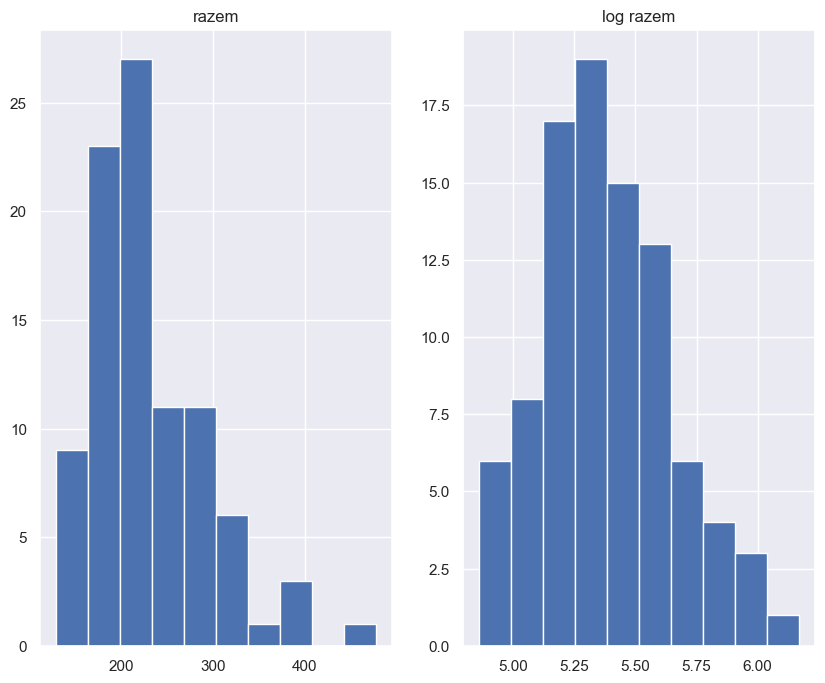

In [54]:
f, ax = plt.subplots(1, 2)
ax[0].hist(full_df_edit['razem'])
ax[0].set_title('razem')
ax[1].hist(np.log(full_df_edit['razem']))
ax[1].set_title('log razem')

# Dzięki transformacji, dystrybucja zbliżyła się do rozkładu normalnego

In [55]:
full_df_edit['log_razem'] = np.log(full_df_edit['razem'])

C:\Users\Balon1\AppData\Local\Temp\ipykernel_16612\2052962089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df_edit['log_razem'] = np.log(full_df_edit['razem'])


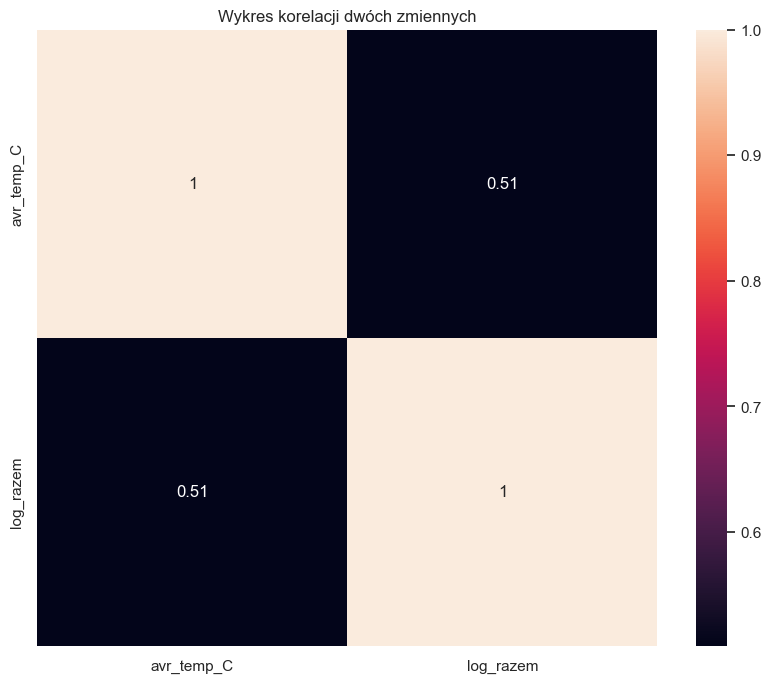

In [56]:
two_cols = ['avr_temp_C', 'log_razem']
sns.heatmap(full_df_edit[two_cols].corr(), annot=True)
plt.title('Wykres korelacji dwóch zmiennych')
plt.show()

# Transformacja wartości poprawiła siłę korelacji z 0.42 do 0.51, co zwiększy skuteczność modelu

# Wytrenowanie modelu na nowych danych, zapis i odczyt

In [57]:
X = full_df_edit['avr_temp_C'].values
y = full_df_edit['log_razem'].values

In [58]:
reg = LinearRegression().fit(X.reshape(-1, 1), y)

In [59]:
y_pred = reg.predict(X.reshape(-1,1))
mse_reg = MSE(y, y_pred)
rmse_reg = mse_reg**0.5
print('Test set RMSE of reg: {:.2f}'.format(rmse_reg))

Test set RMSE of reg: 0.22


In [60]:
np.exp(y_pred)

array([187.45650776, 186.64758163, 200.25578391, 210.7153011 ,
       228.22150591, 243.90003045, 255.88350977, 268.2975034 ,
       239.7643481 , 211.21293968, 204.95513704, 198.92183901,
       172.56768309, 191.47873727, 195.35672388, 212.83839606,
       240.61421335, 255.4814272 , 259.68394465, 255.4814272 ,
       245.14977109, 211.12991838, 194.97308203, 190.9149749 ,
       176.47846803, 180.58434321, 199.86252128, 205.64119053,
       232.61489591, 248.30221051, 251.69301455, 256.38700299,
       237.3260062 , 222.15740017, 200.01973357, 190.35287238,
       184.24168748, 170.20939227, 180.44240682, 224.92572906,
       246.30906081, 255.53165295, 268.77258451, 266.66753138,
       244.66834557, 223.47137676, 199.19574639, 188.56524176,
       179.59312817, 192.61126123, 200.96560767, 214.85614032,
       226.87959931, 269.03688187, 253.33103334, 265.09956818,
       239.5288076 , 222.20107466, 201.79691601, 194.81983632,
       195.5103919 , 196.89885495, 196.70542479, 212.17

In [61]:
filename = 'linear_regression'
outfile = open(filename,'wb')
pickle.dump(reg,outfile)
outfile.close()

In [62]:
model_lr = joblib.load('linear_regression')

In [63]:
np.exp(model_lr.predict([[30]]))

array([330.97295792])

# Próba wykorzystania otrzymanego modelu w 'produkcji'

In [64]:
%%writefile basic_server.py

import joblib
from flask import Flask, request, render_template, escape
from sklearn.linear_model import LinearRegression
import numpy as np

app = Flask(__name__)

def get_pred(avr_temp_C=None):
    model = joblib.load('linear_regression')
    y_pred = model.predict( [[avr_temp_C]] )
    
    return y_pred

@app.route('/', methods=['GET', 'POST'])
def upload_data():
    if request.method == 'POST':
        avr_temp_C = request.values['avr_temp_C']    
        label_pred = get_pred(np.array(avr_temp_C, dtype=float))
        return '''
        <!doctype html>
        <title>Prosta regresja z wykorzystaniem algorytmu regresji liniowej</title>
        <h1>Prosta regresja z wykorzystaniem algorytmu regresji liniowej</h1>
        <p>Wyniki predykcji</p> 
        <p>Średnia miesięczna temperatura: {}</p>
        <p>Przewidywana liczba interwencji straży pożarnej: {} </p>
        '''.format(escape(avr_temp_C), escape(np.round(np.exp(label_pred))))

        
    return '''
    <!doctype html>
    <title>Prosta regresja z wykorzystaniem algorytmu regresji liniowej</title>
    <h1>Prosta regresja z wykorzystaniem algorytmu regresji liniowej</h1>
    <p>Wprowadź średnią miesięczną temperaturę</p>
    <form method=post enctype=multipart/form-data>
      <p><input type="number" name="avr_temp_C">
         <input type=submit value="OK">
    </form>
    '''

Overwriting basic_server.py


# Komendy pod Windowsa

In [65]:
# set FLASK_APP=basic_server.py
# flask run

# Gotową aplikację można obejrzeć pod adresem:

http://krsolowiej.pythonanywhere.com/

# Bonus: niewykorzystane modele i eksperymenty

# Model regresji wielokrotnej uwzględniający interakcje zmiennych

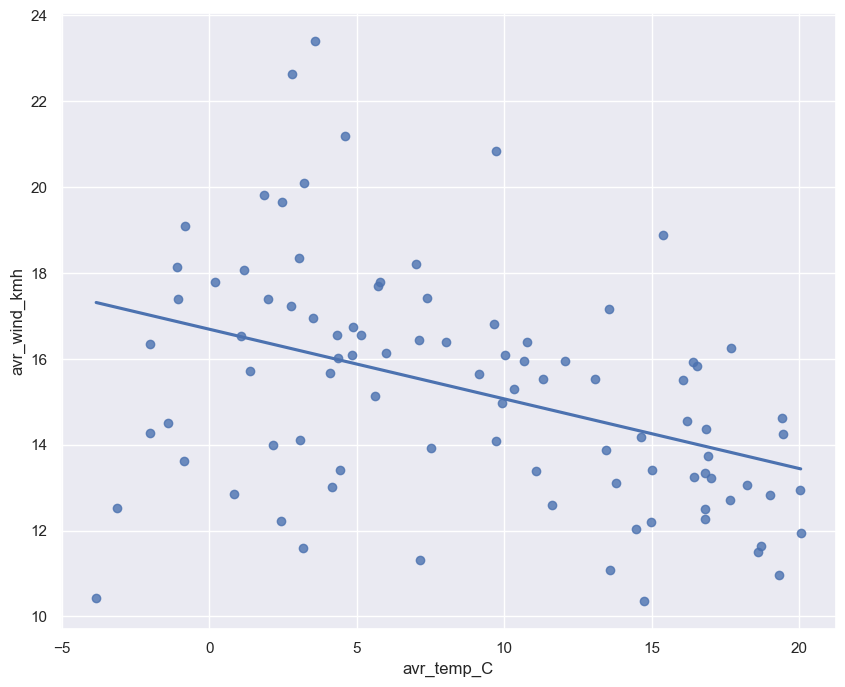

In [66]:
sns.regplot(x="avr_temp_C", y="avr_wind_kmh", data=full_df_edit, ci=None)
plt.show()

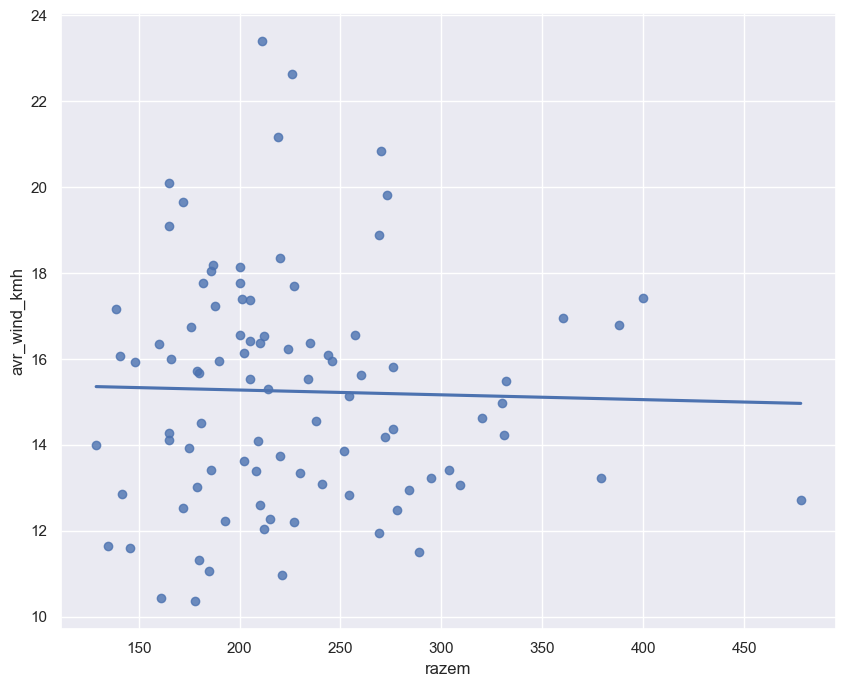

In [67]:
sns.regplot(x="razem", y="avr_wind_kmh", data=full_df_edit, ci=None)
plt.show()

In [68]:
razem_vs_avr_wind = smf.ols('log_razem ~ avr_temp_C * avr_wind_kmh', data=full_df_edit).fit()
razem_vs_avr_wind.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_razem   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     13.13
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           3.68e-07
Time:                        14:17:30   Log-Likelihood:                 10.099
No. Observations:                  92   AIC:                            -12.20
Df Residuals:                      88   BIC:                            -2.111
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.8345      0.216     22.410      0.000       4.406       5.263
avr_temp_C                  0.0210      0.022      0.967      0.336      -0.022       0.064
avr_wind_kmh                0.0225      0.013      1.675      0.097      -0.004       0.049
avr_temp_C:avr_wind_kmh     0.0002      0.002      0.118      0.906      -0.003       0.003
==============================================================================
Omnibus:                        8.293   Durbin-Watson:                   1.200
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               15.724
Skew:                           0.193   Prob(JB):                     0.000385
Kurtosis:                       4.988   Cond. No.                     1.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

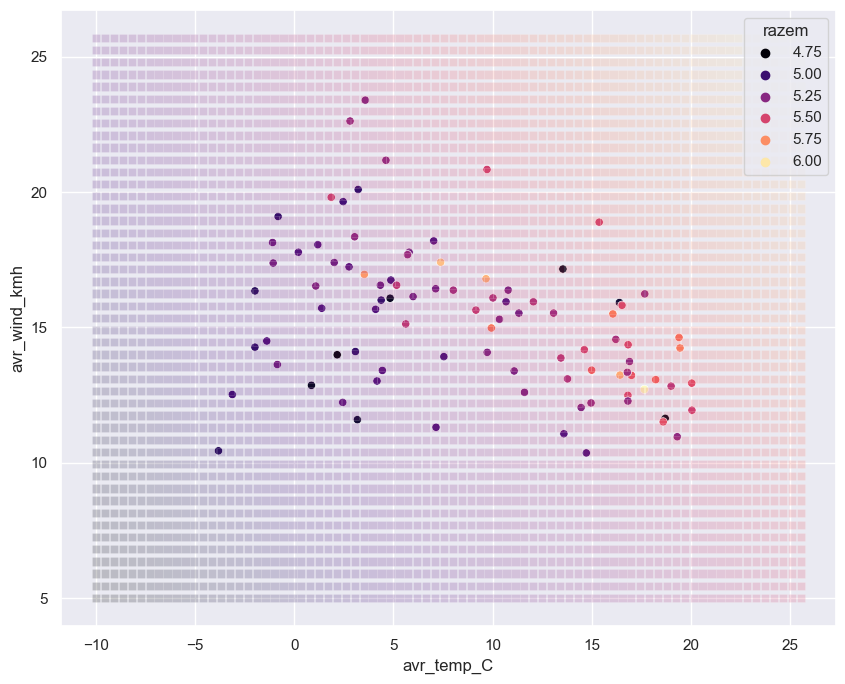

In [69]:
avr_temp_C = np.arange(-10, 26, 0.45)
avr_wind_kmh = np.arange(5, 26, 0.45)
p = product(avr_temp_C, avr_wind_kmh)
explanatory_data = pd.DataFrame(p, columns=["avr_temp_C", "avr_wind_kmh"])
prediction_data = explanatory_data.assign(
    razem = razem_vs_avr_wind.predict(explanatory_data))

sns.scatterplot(x="avr_temp_C", y="avr_wind_kmh", data=full_df_edit, hue="log_razem", palette='magma', legend=False)
sns.scatterplot(x="avr_temp_C", y="avr_wind_kmh", data=prediction_data, hue="razem", palette='magma', marker="s", alpha=0.2)
plt.show()

# Prosta regresja z wykorzystaniem algorytmu drzewa decyzyjnego

In [70]:
full_df_edit

,data,liczba_falszywych_alarmow,liczba_zagrozen_miejscowych,liczba_pozarow,razem,rok,miesiac,avr_temp_C,max_temp_C,min_temp_C,avr_wind_kmh,avr_press_hPa,temp_diff,leverage,cooks_dist,log_razem
0,2015-01-01,12,172,28,212,2015,01,1.08,8.89,-7.78,16.53,991.87,16.67,0.011416,7.463281e-03,5.356586
1,2015-02-01,11,92,39,142,2015,02,0.86,8.89,-11.11,12.86,997.63,20.00,0.028772,7.075906e-03,4.955827
2,2015-03-01,10,110,66,186,2015,03,4.44,17.22,-2.78,13.41,1001.36,20.00,0.015114,1.297407e-03,5.225747
3,2015-04-01,8,114,65,187,2015,04,7.03,22.22,-2.22,18.20,997.97,24.44,0.014912,6.960930e-08,5.231109
4,2015-05-01,10,141,57,208,2015,05,11.09,22.78,2.22,13.39,996.95,20.56,0.011773,1.585307e-03,5.337538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2022-05-01,14,128,63,205,2022,05,11.33,26.11,0.00,15.53,999.32,26.11,0.012092,2.029344e-03,5.323010
89,2022-06-01,16,178,36,230,2022,06,16.80,31.11,6.11,13.34,998.98,25.00,0.010757,9.033823e-03,5.438079
90,2022-07-01,14,183,27,224,2022,07,17.68,33.89,10.00,16.24,1000.00,23.89,0.010804,1.185838e-02,5.411646
91,2022-08-01,16,216,37,269,2022,08,20.06,32.78,10.00,11.94,1001.02,22.78,0.014671,1.787398e-02,5.594711


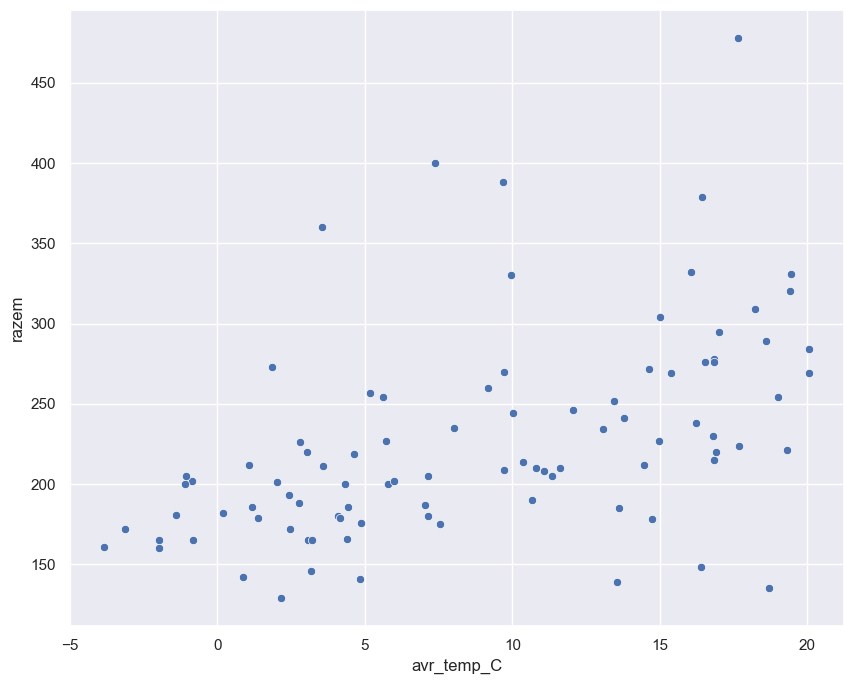

In [71]:
sns.scatterplot(full_df_edit, x='avr_temp_C', y='razem')
plt.show()

In [72]:
X = full_df_edit['avr_temp_C'].values
y = full_df_edit['razem'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [73]:
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=22)
dt.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=22)

In [74]:
y_pred = dt.predict(X_test.reshape(-1,1))
mse_dt = MSE(y_test, y_pred)
rmse_dt = mse_dt**0.5
print('Test set RMSE of rf: {:.2f}'.format(rmse_dt))

Test set RMSE of rf: 43.23


In [75]:
y_pred

array([225.2       , 225.2       , 257.75      , 259.25      ,
       257.75      , 259.25      , 181.7       , 210.85714286,
       259.25      , 259.25      , 210.85714286, 176.3       ,
       181.7       , 259.25      , 181.7       , 181.7       ,
       210.85714286, 210.85714286, 280.23076923])

Zapisywanie modelu

In [76]:
filename = 'tree_regressor'
outfile = open(filename,'wb')
pickle.dump(dt,outfile)
outfile.close()

In [77]:
model = joblib.load('tree_regressor')

In [78]:
model.predict([[6]])

array([210.85714286])

# Random Forest Regressor

In [79]:
X = full_df_edit['avr_temp_C'].values
y = full_df_edit['razem'].values
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Ustalanie najlepszych parametrów

In [80]:
rf = RandomForestRegressor(random_state=SEED)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [81]:
params_rf = {'n_estimators': [400,500,600], 'max_depth': [1,2,3], 'min_samples_leaf': [0.3, 0.4, 0.5], 'max_features': ['log2', 'sqrt']}
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [82]:
grid_rf.fit(X_train.reshape(-1,1), y_train)
best_hyperparams = grid_rf.best_params_
print('Best hyperparams:\n', best_hyperparams)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best hyperparams:
 {'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 0.3, 'n_estimators': 400}


In [83]:
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train.reshape(-1,1), y_train)

RandomForestRegressor(max_depth=1, max_features='log2', min_samples_leaf=0.3,
                      n_estimators=400, random_state=1)

In [84]:
y_pred = best_rf.predict(X_test.reshape(-1,1))
y_pred

array([203.98614124, 203.98614124, 254.04827667, 254.04827667,
       203.98614124, 250.00672121, 203.98614124, 254.04827667,
       254.04827667, 253.25379627, 254.04827667, 254.04827667,
       254.04827667, 206.7233936 , 203.98614124, 254.04827667,
       206.7233936 , 203.98614124, 254.04827667, 254.04827667,
       203.98614124, 254.04827667, 206.7233936 , 203.98614124,
       250.3114647 , 254.04827667, 203.98614124, 254.04827667])

In [85]:
rmse_test = MSE(y_test, y_pred) ** 0.5
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 47.05


# Zapis i odczyt modelu

In [86]:
filename = 'rand_forest'
outfile = open(filename,'wb')
pickle.dump(best_rf,outfile)
outfile.close()

In [87]:
model_rf = joblib.load('rand_forest')

In [88]:
model_rf.predict([[16]])

array([254.04827667])

# Gradient Boosting Regressor

In [89]:
gb = GradientBoostingRegressor(n_estimators=20, max_depth=1, random_state=SEED)
gb.fit(X_train.reshape(-1,1), y_train)
y_pred = gb.predict(X_test.reshape(-1,1))

In [90]:
rmse_test = MSE(y_test, y_pred) ** 0.5
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 49.77


# Stochastic Gradient Boosting

In [91]:
stgb = GradientBoostingRegressor(max_depth=1, subsample=0.8, max_features=0.2, n_estimators=20, random_state=SEED)
stgb.fit(X_train.reshape(-1,1), y_train)
y_pred = stgb.predict(X_test.reshape(-1,1))

In [92]:
rmse_test = MSE(y_test, y_pred) ** 0.5
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 49.67


In [93]:
filename = 'gradient_boost'
outfile = open(filename,'wb')
pickle.dump(stgb,outfile)
outfile.close()
model_gb = joblib.load('gradient_boost')

In [94]:
model_gb.predict([[16]])

array([269.98298429])